In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys

# 配置搜索路径
sys.path.append("./")
sys.path.append("../")
sys.path.append("../../")
import backtrader as bt
import pandas as pd
import pprint
import sqlite3
from tqdm import tqdm
from datetime import datetime
from strategies import CustomMLStrategy
from backtest_utils import CustomCommissionSchema, CustomAnalyzer
from Share.database.downloader.downloader_base import DownloaderBase
import Share.database.database_config as db_config

In [2]:
BACKTEST_INITIAL_CASH = 100000  # 初始化资金
BACKTEST_INDEX_SYMBOLS = "000016"  # 【选股】策略的对比基准=指数index，【择时】策略的对比基准=单股自身

# 读取模型预测文件
model_pred_df = pd.read_pickle("./backtest_data/stock_selection_result.pkl")
# 构建数据里表
BACKTEST_STOCK_SYMBOLS = model_pred_df['stock_code'].map(lambda x: str(x).zfill(6)).unique().tolist()
BACKTEST_START_DATE = datetime.strptime(model_pred_df['datetime'].min(), "%Y-%m-%d").strftime("%Y%m%d")  # 回测开始日期
BACKTEST_END_DATE = datetime.strptime(model_pred_df['datetime'].max(), "%Y-%m-%d").strftime("%Y%m%d")  # 回测结束日期
print(f'Start: {BACKTEST_START_DATE}, End: {BACKTEST_END_DATE}')

Start: 20210701, End: 20210930


In [3]:
# 初始化db_downloader
db_conn = sqlite3.connect("../../Share/database/hh_quant.db")
db_downloader = DownloaderBase(db_conn=db_conn, db_config=db_config)

In [4]:
cerebro = bt.Cerebro()

In [5]:
print("开始设置回测基础参数...")
cerebro.broker.setcash(BACKTEST_INITIAL_CASH)  # 配置初始资金量
cerebro.broker.addcommissioninfo(CustomCommissionSchema())  # 配置自定义的佣金类型

开始设置回测基础参数...


In [6]:
print("开始添加回测股票数据...")
for stock_symbol in tqdm(BACKTEST_STOCK_SYMBOLS):
    stock_data = db_downloader._download_stock_history_info(stock_symbol, start_date=BACKTEST_START_DATE, end_date=BACKTEST_END_DATE)
    if not stock_data.empty:
        stock_data = stock_data[["datetime", "open", "high", "low", "close", "volume"]]
        stock_data["datetime"] = pd.to_datetime(stock_data["datetime"])
        stock_data.set_index("datetime", inplace=True)
        stock_data_feeds = bt.feeds.PandasData(dataname=stock_data)  # 构建回测数据Feeds流
        cerebro.adddata(stock_data_feeds, name=stock_symbol)  # 添加回测数据

开始添加回测股票数据...


100%|██████████| 48/48 [00:00<00:00, 707.05it/s]


In [7]:
print("开始添加基准数据...")
benchmark_data = db_downloader._download_index_history_info(BACKTEST_INDEX_SYMBOLS, start_date=BACKTEST_START_DATE, end_date=BACKTEST_END_DATE)
benchmark_data = benchmark_data[["datetime", "open", "high", "low", "close", "volume"]]
benchmark_data["datetime"] = pd.to_datetime(benchmark_data["datetime"])
benchmark_data.set_index("datetime", inplace=True)
benchmark_name = f"benchmark_{BACKTEST_INDEX_SYMBOLS}"
benchmark_data_feeds = bt.feeds.PandasData(dataname=benchmark_data)  # 构建基准数据Feeds流
cerebro.adddata(benchmark_data_feeds, name=benchmark_name)  # 添加基准数据

开始添加基准数据...


In [8]:
print("开始添加策略...")
strategy_params = {
        "model_prediction_file": "./backtest_data/stock_selection_result.pkl",
        "benchmark": benchmark_name
    }
cerebro.addstrategy(CustomMLStrategy, **strategy_params)

开始添加策略...


0

In [9]:
print("开始添加分析器...")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")  # 添加最大回撤的分析器，后续customAnalyzer中需要用到
cerebro.addanalyzer(CustomAnalyzer, _name="custom_analyzer")  # 添加自定义的分析器
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

开始添加分析器...


In [10]:
print("开始添加观察器...")
cerebro.addobserver(bt.observers.Benchmark, data=benchmark_data_feeds, timeframe=bt.TimeFrame.NoTimeFrame)  # 添加基准对比观察器

开始添加观察器...


In [11]:
print("开始运行回测...")
# 运行回测
results = cerebro.run()
# 打印初始资金
print(f"Start Portfolio Value: {BACKTEST_INITIAL_CASH}")
# 打印最终资金
print(f"Final Portfolio Value: {cerebro.broker.getvalue()}")

开始运行回测...
启动基准对比...
{'stock_code': ['601919'], 'stock_name': ['中远海控'], 'datetime': ['2021-07-12'], 'future_return': [-0.03443708609271523], 'future_return_pred': [0.01805240660905838]}
{'stock_code': ['601899'], 'stock_name': ['紫金矿业'], 'datetime': ['2021-07-12'], 'future_return': [-0.046288209606986874], 'future_return_pred': [0.017153644934296608]}
{'stock_code': ['600309'], 'stock_name': ['万华化学'], 'datetime': ['2021-07-12'], 'future_return': [-0.04094377492542345], 'future_return_pred': [0.013499537482857704]}
{'stock_code': ['600809'], 'stock_name': ['山西汾酒'], 'datetime': ['2021-07-12'], 'future_return': [0.10614998269373799], 'future_return_pred': [0.012924699112772942]}
{'stock_code': ['600438'], 'stock_name': ['通威股份'], 'datetime': ['2021-07-12'], 'future_return': [-0.06195050946142644], 'future_return_pred': [0.012668730691075325]}
2021-07-13 买入执行, 引用: 1, 价格: 30.20, 成本: 14224.20, 手续费: 5.00, 数量: 471.00, 股票: 601919
2021-07-13 买入执行, 引用: 2, 价格: 171.75, 成本: 29025.75, 手续费: 5.00, 数量: 169

开始打印回测相关指标...
{'其他': {'亏损次数': 49,
        '夏普比率': 1.819,
        '日均超额收益': 0.0026,
        '日胜率': 0.5079,
        '最大回撤': 4.5445,
        '最大回撤区间': 2,
        '盈亏比': 1.609,
        '盈利次数': 41,
        '索提诺比率': 3.2706,
        '胜率': 0.4556,
        '贝塔': 0.4198,
        '超额收益': 0.1626,
        '超额收益夏普比率': 3.7923,
        '阿尔法': 0.0017},
 '基准': {'基准年化收益': -0.327, '基准收益': -0.0957, '基准波动率': 0.2129},
 '策略': {'策略年化收益': 0.2903, '策略收益': 0.0669, '策略波动率': 0.1485}}


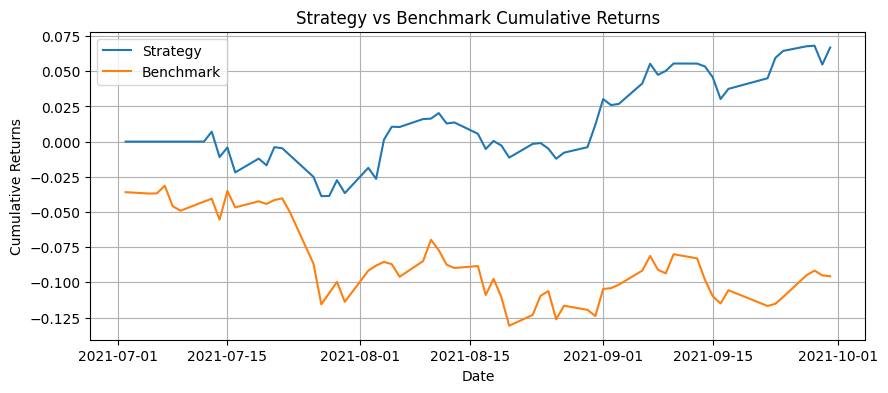

In [12]:
print("开始打印回测相关指标...")
def plot_strategy_benchmark_returns(strategy_returns, benchmark_returns):
    import matplotlib.pyplot as plt
    # 检查index是否一致以保证对齐
    if not strategy_returns.index.equals(benchmark_returns.index):
        raise ValueError("Indexes of strategy_returns and benchmark_returns must match")
    # 计算累积收益率
    strategy_cumulative_returns = (1 + strategy_returns).cumprod() - 1
    benchmark_cumulative_returns = (1 + benchmark_returns).cumprod() - 1
    # 绘制累积收益率曲线
    plt.figure(figsize=(10,4))
    plt.plot(strategy_cumulative_returns, label='Strategy')
    plt.plot(benchmark_cumulative_returns, label='Benchmark')
    # 添加标题和标签
    plt.title('Strategy vs Benchmark Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    # 显示图例
    plt.legend()
    # 显示网格
    plt.grid(True)
    # 显示绘制的图形
    plt.show()

custom_analysis = results[0].analyzers.custom_analyzer.get_analysis()
format_analysis_result = {"基准": {}, "策略": {}, "其他": {}}
for key, value in custom_analysis.items():
    if key.startswith("基准"):
        format_analysis_result["基准"][key] = round(value, 4)
    elif key.startswith("策略"):
        format_analysis_result["策略"][key] = round(value, 4)
    else:
        format_analysis_result["其他"][key] = round(value, 4)
pprint.pprint(format_analysis_result)

strategy_returns = pd.Series(results[0].analyzers.custom_analyzer.get_strategy_returns(), index=benchmark_data.index[1:])
benchmark_returns = pd.Series(results[0].analyzers.custom_analyzer.get_benchmark_returns(), index=benchmark_data.index[1:])
plot_strategy_benchmark_returns(strategy_returns, benchmark_returns)